**Generalized Additive Model from Scratch**

In [43]:
import numpy as np
import matplotlib.pyplot as plt


In [44]:
#Generat Sample Data
np.random.seed(1)

n = 200
#x = np.linspace(0, 10, n)
#y = np.sin(x) + 0.25 * np.random.randn(n)

#x = np.linspace(0, 10, 50)
#y = np.sin(x) + 0.3 * np.random.randn(50)

x = np.sort(np.random.beta(2, 5, 50) * 10)
y = np.sin(x) + 0.25 * np.random.randn(50)

In [45]:
#Build B - Spline Basis
def bspline_basis(x, knots, degree=3):
    """
    Construct B-spline basis using Cox–de Boor recursion
    """
    n = len(x)
    k = degree
    t = np.concatenate(([knots[0]]*k, knots, [knots[-1]]*k))
    m = len(t) - k - 1

    B = np.zeros((n, m))

    # Zeroth degree
    for i in range(m):
        B[:, i] = ((t[i] <= x) & (x < t[i+1])).astype(float)

    # Higher degrees
    for d in range(1, k+1):
        for i in range(m):
            denom1 = t[i+d] - t[i]
            denom2 = t[i+d+1] - t[i+1]

            term1 = ((x - t[i]) / denom1) * B[:, i] if denom1 > 0 else 0
            term2 = ((t[i+d+1] - x) / denom2) * B[:, i+1] if denom2 > 0 else 0

            B[:, i] = term1 + term2

    return B[:, :len(knots)]


In [46]:
#Smoothness Penalty
def second_difference_penalty(K):
    D = np.zeros((K-2, K))
    for i in range(K-2):
        D[i, i:i+3] = [1, -2, 1]
    return D.T @ D


In [47]:
# Knots
K = 15
knots = np.linspace(x.min(), x.max(), K)

# Basis matrix
B = bspline_basis(x, knots)

# Add intercept
X = np.column_stack((np.ones(len(x)), B))

# Penalty matrix
S = np.zeros((X.shape[1], X.shape[1]))
S[1:, 1:] = second_difference_penalty(B.shape[1])


In [48]:
#Penalty Least Squares Solver
def fit_gam(X, y, S, lam):
    n, p = X.shape
    I = np.eye(p)
    beta = np.linalg.solve(X.T @ X + lam * S, X.T @ y)
    return beta



In [49]:
#GAM Fitting to the Data

lam = 10.0  # smoothing parameter
beta = fit_gam(X, y, S, lam)

y_hat = X @ beta


In [50]:
#Computing the confidence interval
n = len(y)
residuals = y - y_hat

# effective degrees of freedom (approx)
edf = np.trace(X @ np.linalg.inv(X.T @ X + lam * S) @ X.T)

sigma2 = np.sum(residuals**2) / (n - edf)


XtX = X.T @ X
A = np.linalg.inv(XtX + lam * S)

Cov_beta = sigma2 * A @ XtX @ A


var_yhat = np.sum(X * (X @ Cov_beta), axis=1)
std_yhat = np.sqrt(var_yhat)


z = 1.96  # 95% CI

y_upper = y_hat + z * std_yhat
y_lower = y_hat - z * std_yhat




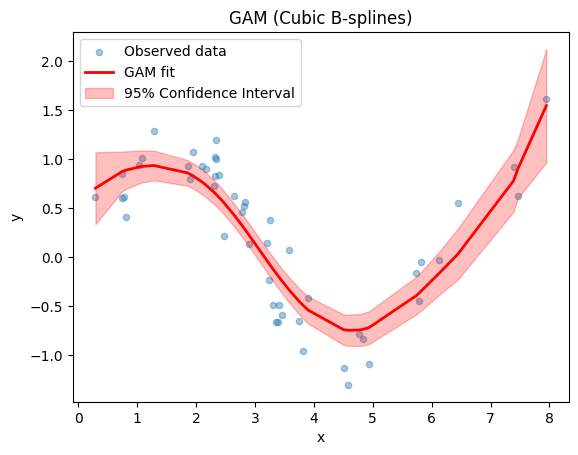

In [51]:
#Plot

#Confidence Interval
plt.scatter(x, y, s=20, alpha=0.4, label="Observed data")
plt.plot(x, y_hat, color="red", lw=2, label="GAM fit")

plt.fill_between(
    x,
    y_lower,
    y_upper,
    color="red",
    alpha=0.25,
    label="95% Confidence Interval"
)

plt.legend()
plt.title("GAM with 95% Confidence Interval")
plt.xlabel("x")
plt.ylabel("y")

plt.legend()
plt.title("GAM (Cubic B-splines)")
plt.show()
